# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1

MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
torch.cuda.is_available()

True


### Dataset


In [5]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

### Model Training

#### L1 loss

In [211]:
class ConvNet_L1Loss(nn.Module):
    def __init__(self):
        super(ConvNet_L1Loss, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model_L1Loss = ConvNet_L1Loss()
model_L1Loss.to(device)

criterion_L1Loss = nn.L1Loss(reduction='mean')
optimizer = optim.SGD(model_L1Loss.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

def train_batch_L1Loss(model, image, target):
    output = F.softmax(model(image),dim=1)
    target_tensor = torch.zeros(len(target),10)
    target_tensor = target_tensor.to(device)
    for i in range(len(target)):
        target_tensor[i][target[i]] = 1.0
    loss = criterion_L1Loss(output,target_tensor)
    return output, loss

def test_batch_L1Loss(model, image, target):
    output = F.softmax(model(image),dim=1)
    target_tensor = torch.zeros(len(target),10)
    target_tensor = target_tensor.to(device)  
    for i in range(len(target)):
        target_tensor[i][target[i]] = 1.0
    loss = criterion_L1Loss(output,target_tensor)
    return output, loss

In [212]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model_L1Loss.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch_L1Loss(model_L1Loss, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model_L1Loss.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch_L1Loss(model_L1Loss, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
#         if (epoch +1) == NUM_EPOCHS:
            
#             state = {
#             'state_dict': model_SmoothL1Loss.state_dict(),
#             'acc': epoch_acc,
#             'epoch': (epoch+1),
#             }

#             # check the dir
#             if not os.path.exists(SAVE_DIR):
#                 os.makedirs(SAVE_DIR)

#             # save the state
#             torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
            
training_loss_L1 = training_loss.copy()
training_acc_L1 = training_acc.copy()
testing_loss_L1 = testing_loss.copy()
testing_acc_L1 = testing_acc.copy()

Epoch: 1/30 Train Loss: 0.0013 Acc: 0.1382
Begin test......
Test Loss: 0.0012 Acc: 0.2163
Epoch: 2/30 Train Loss: 0.0012 Acc: 0.2268
Begin test......
Test Loss: 0.0012 Acc: 0.2488
Epoch: 3/30 Train Loss: 0.0012 Acc: 0.2509
Begin test......
Test Loss: 0.0011 Acc: 0.2905
Epoch: 4/30 Train Loss: 0.0011 Acc: 0.2806
Begin test......
Test Loss: 0.0011 Acc: 0.3019
Epoch: 5/30 Train Loss: 0.0011 Acc: 0.2958
Begin test......
Test Loss: 0.0011 Acc: 0.3163
Epoch: 6/30 Train Loss: 0.0011 Acc: 0.3118
Begin test......
Test Loss: 0.0010 Acc: 0.3375
Epoch: 7/30 Train Loss: 0.0011 Acc: 0.3189
Begin test......
Test Loss: 0.0010 Acc: 0.3380
Epoch: 8/30 Train Loss: 0.0011 Acc: 0.3193
Begin test......
Test Loss: 0.0010 Acc: 0.3389
Epoch: 9/30 Train Loss: 0.0011 Acc: 0.3236
Begin test......
Test Loss: 0.0010 Acc: 0.3416
Epoch: 10/30 Train Loss: 0.0011 Acc: 0.3264
Begin test......
Test Loss: 0.0010 Acc: 0.3456
Epoch: 11/30 Train Loss: 0.0010 Acc: 0.3308
Begin test......
Test Loss: 0.0010 Acc: 0.3522
Epoch: 1

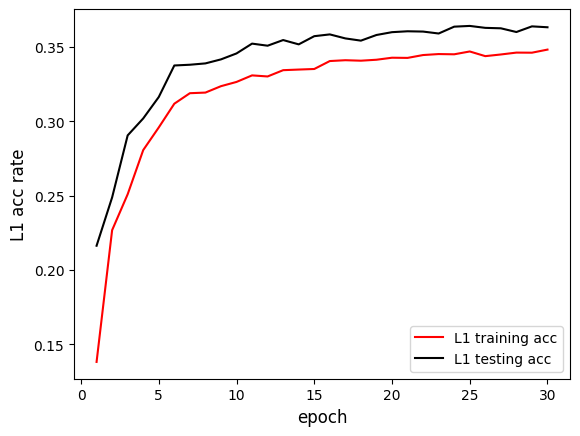

In [213]:
plt.plot(list(range(1,31)),training_acc_L1,color='r',label="L1 training acc")
plt.plot(list(range(1,31)),testing_acc_L1,color='black',label="L1 testing acc")
plt.xlabel("epoch",size=12)
plt.ylabel("L1 acc rate",size=12)
plt.legend()

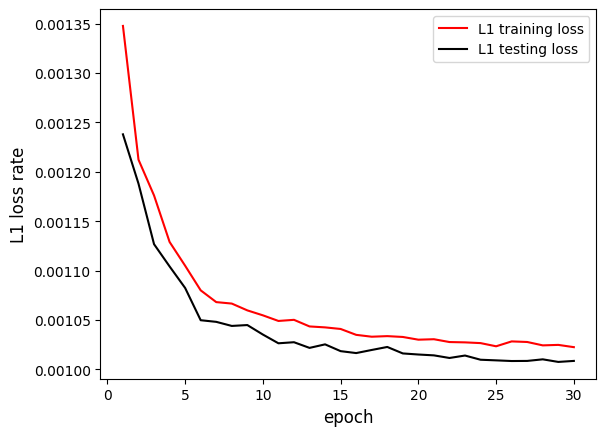

In [214]:
plt.plot(list(range(1,31)),training_loss_L1,color='r',label='L1 training loss')
plt.plot(list(range(1,31)),testing_loss_L1,color='black',label='L1 testing loss')
plt.xlabel("epoch",size=12)
plt.ylabel("L1 loss rate",size=12)
plt.legend()

#### Smooth L1 loss

In [215]:
class ConvNet_SmoothL1Loss(nn.Module):
    def __init__(self):
        super(ConvNet_SmoothL1Loss, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model_SmoothL1Loss = ConvNet_SmoothL1Loss()
model_SmoothL1Loss.to(device)

criterion_SmoothL1Loss = nn.SmoothL1Loss(reduction='mean')
optimizer = optim.SGD(model_SmoothL1Loss.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

def train_batch_SmoothL1Loss(model, image, target):
    output = F.softmax(model(image),dim=1)
    target_tensor = torch.zeros(len(target),10)
    target_tensor = target_tensor.to(device)
    for i in range(len(target)):
        target_tensor[i][target[i]] = 1.0
    loss = criterion_SmoothL1Loss(output,target_tensor)
    return output, loss

def test_batch_SmoothL1Loss(model, image, target):
    output = F.softmax(model(image),dim=1)
    target_tensor = torch.zeros(len(target),10)
    target_tensor = target_tensor.to(device)  
    for i in range(len(target)):
        target_tensor[i][target[i]] = 1.0
    loss = criterion_SmoothL1Loss(output,target_tensor)
    return output, loss

In [216]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model_SmoothL1Loss.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch_SmoothL1Loss(model_SmoothL1Loss, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model_SmoothL1Loss.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch_SmoothL1Loss(model_SmoothL1Loss, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
#         if (epoch +1) == NUM_EPOCHS:
            
#             state = {
#             'state_dict': model_SmoothL1Loss.state_dict(),
#             'acc': epoch_acc,
#             'epoch': (epoch+1),
#             }

#             # check the dir
#             if not os.path.exists(SAVE_DIR):
#                 os.makedirs(SAVE_DIR)

#             # save the state
#             torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
            
training_loss_SmoothL1 = training_loss.copy()
training_acc_SmoothL1 = training_acc.copy()
testing_loss_SmoothL1 = testing_loss.copy()
testing_acc_SmoothL1 = testing_acc.copy()

Epoch: 1/30 Train Loss: 0.0003 Acc: 0.1279
Begin test......
Test Loss: 0.0003 Acc: 0.1837
Epoch: 2/30 Train Loss: 0.0003 Acc: 0.2343
Begin test......
Test Loss: 0.0003 Acc: 0.2829
Epoch: 3/30 Train Loss: 0.0003 Acc: 0.2777
Begin test......
Test Loss: 0.0003 Acc: 0.3233
Epoch: 4/30 Train Loss: 0.0003 Acc: 0.3167
Begin test......
Test Loss: 0.0003 Acc: 0.3712
Epoch: 5/30 Train Loss: 0.0003 Acc: 0.3551
Begin test......
Test Loss: 0.0003 Acc: 0.3969
Epoch: 6/30 Train Loss: 0.0003 Acc: 0.3815
Begin test......
Test Loss: 0.0003 Acc: 0.4202
Epoch: 7/30 Train Loss: 0.0003 Acc: 0.3960
Begin test......
Test Loss: 0.0003 Acc: 0.4333
Epoch: 8/30 Train Loss: 0.0003 Acc: 0.4032
Begin test......
Test Loss: 0.0003 Acc: 0.4463
Epoch: 9/30 Train Loss: 0.0003 Acc: 0.4124
Begin test......
Test Loss: 0.0003 Acc: 0.4516
Epoch: 10/30 Train Loss: 0.0003 Acc: 0.4192
Begin test......
Test Loss: 0.0003 Acc: 0.4577
Epoch: 11/30 Train Loss: 0.0003 Acc: 0.4277
Begin test......
Test Loss: 0.0003 Acc: 0.4677
Epoch: 1

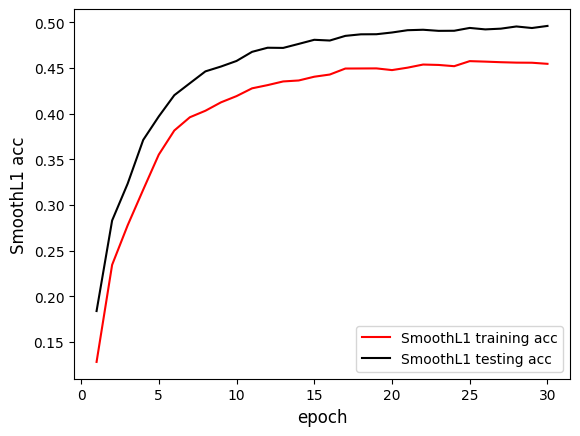

In [217]:
plt.plot(list(range(1,31)),training_acc_SmoothL1,color='r',label='SmoothL1 training acc')
plt.plot(list(range(1,31)),testing_acc_SmoothL1,color='black',label='SmoothL1 testing acc')
plt.xlabel("epoch",size=12)
plt.ylabel("SmoothL1 acc",size=12)
plt.legend()

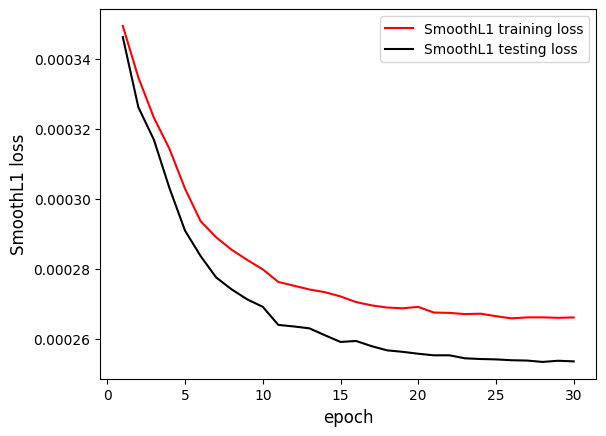

In [218]:
plt.plot(list(range(1,31)),training_loss_SmoothL1,color='r',label='SmoothL1 training loss')
plt.plot(list(range(1,31)),testing_loss_SmoothL1,color='black',label='SmoothL1 testing loss')
plt.xlabel('epoch',size=12)
plt.ylabel('SmoothL1 loss',size=12)
plt.legend()

#### CE loss

In [219]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
#         F.softmax(x,dim=1)
        return x

model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
criterion = nn.CrossEntropyLoss()

def train_batch(model, image, target):
    output = model(image)
    loss =  criterion(output,target)
    return output, loss

def test_batch(model, image, target):
    output = model(image)
    loss = criterion(output,target)
    return output, loss

In [220]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
#         if (epoch +1) == NUM_EPOCHS:
            
#             state = {
#             'state_dict': model.state_dict(),
#             'acc': epoch_acc,
#             'epoch': (epoch+1),
#             }

#             # check the dir
#             if not os.path.exists(SAVE_DIR):
#                 os.makedirs(SAVE_DIR)

#             # save the state
#             torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
            
training_loss_CE = training_loss.copy()
training_acc_CE = training_acc.copy()
testing_loss_CE = testing_loss.copy()
testing_acc_CE = testing_acc.copy()

Epoch: 1/30 Train Loss: 0.0149 Acc: 0.2844
Begin test......
Test Loss: 0.0142 Acc: 0.3176
Epoch: 2/30 Train Loss: 0.0139 Acc: 0.3433
Begin test......
Test Loss: 0.0129 Acc: 0.3960
Epoch: 3/30 Train Loss: 0.0138 Acc: 0.3484
Begin test......
Test Loss: 0.0135 Acc: 0.3682
Epoch: 4/30 Train Loss: 0.0137 Acc: 0.3573
Begin test......
Test Loss: 0.0131 Acc: 0.3941
Epoch: 5/30 Train Loss: 0.0136 Acc: 0.3619
Begin test......
Test Loss: 0.0128 Acc: 0.4007
Epoch: 6/30 Train Loss: 0.0127 Acc: 0.4041
Begin test......
Test Loss: 0.0121 Acc: 0.4411
Epoch: 7/30 Train Loss: 0.0126 Acc: 0.4101
Begin test......
Test Loss: 0.0117 Acc: 0.4535
Epoch: 8/30 Train Loss: 0.0125 Acc: 0.4204
Begin test......
Test Loss: 0.0120 Acc: 0.4447
Epoch: 9/30 Train Loss: 0.0124 Acc: 0.4190
Begin test......
Test Loss: 0.0116 Acc: 0.4695
Epoch: 10/30 Train Loss: 0.0123 Acc: 0.4321
Begin test......
Test Loss: 0.0117 Acc: 0.4632
Epoch: 11/30 Train Loss: 0.0117 Acc: 0.4593
Begin test......
Test Loss: 0.0112 Acc: 0.4977
Epoch: 1

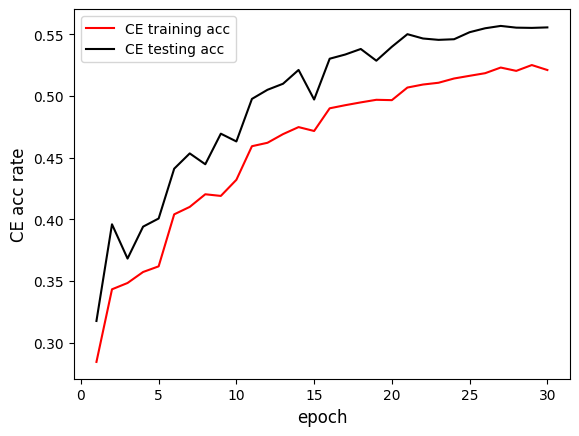

In [221]:
plt.plot(list(range(1,31)),training_acc_CE,color='r',label='CE training acc')
plt.plot(list(range(1,31)),testing_acc_CE,color='black',label='CE testing acc')
plt.xlabel('epoch',size=12)
plt.ylabel('CE acc rate',size=12)
plt.legend()

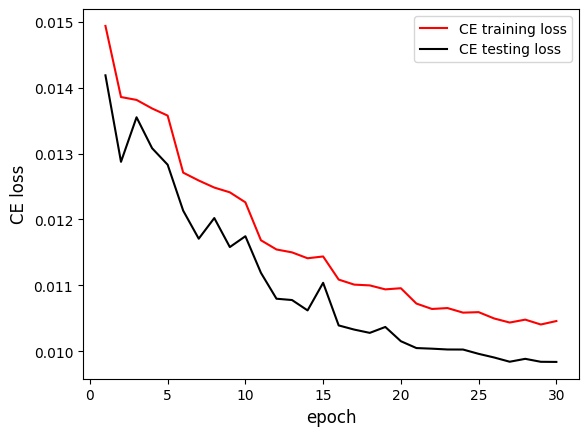

In [222]:
plt.plot(list(range(1,31)),training_loss_CE,color='r',label='CE training loss')
plt.plot(list(range(1,31)),testing_loss_CE,color='black',label='CE testing loss')
plt.xlabel('epoch',size=12)
plt.ylabel('CE loss',size=12)
plt.legend()

#### Focal loss (gamma=0.5)

In [223]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
#         F.softmax(x,dim=1)
        return x

model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

In [224]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=0.5, reduction='none'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        ).mean()

In [225]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
criterion = FocalLoss()

def train_batch(model, image, target):
    output = model(image)
    loss =  criterion(output,target)
    return output, loss

def test_batch(model, image, target):
    output = model(image)
    loss = criterion(output,target)
    return output, loss

In [226]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
#         if (epoch +1) == NUM_EPOCHS:
            
#             state = {
#             'state_dict': model.state_dict(),
#             'acc': epoch_acc,
#             'epoch': (epoch+1),
#             }

#             # check the dir
#             if not os.path.exists(SAVE_DIR):
#                 os.makedirs(SAVE_DIR)

#             # save the state
#             torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
            
training_loss_Focal1 = training_loss.copy()
training_acc_Focal1 = training_acc.copy()
testing_loss_Focal1 = testing_loss.copy()
testing_acc_Focal1 = testing_acc.copy()

Epoch: 1/30 Train Loss: 0.0138 Acc: 0.2890
Begin test......
Test Loss: 0.0129 Acc: 0.3500
Epoch: 2/30 Train Loss: 0.0126 Acc: 0.3530
Begin test......
Test Loss: 0.0128 Acc: 0.3689
Epoch: 3/30 Train Loss: 0.0126 Acc: 0.3553
Begin test......
Test Loss: 0.0120 Acc: 0.3873
Epoch: 4/30 Train Loss: 0.0122 Acc: 0.3755
Begin test......
Test Loss: 0.0120 Acc: 0.3810
Epoch: 5/30 Train Loss: 0.0123 Acc: 0.3672
Begin test......
Test Loss: 0.0116 Acc: 0.4065
Epoch: 6/30 Train Loss: 0.0112 Acc: 0.4183
Begin test......
Test Loss: 0.0104 Acc: 0.4577
Epoch: 7/30 Train Loss: 0.0110 Acc: 0.4297
Begin test......
Test Loss: 0.0103 Acc: 0.4830
Epoch: 8/30 Train Loss: 0.0109 Acc: 0.4405
Begin test......
Test Loss: 0.0102 Acc: 0.4829
Epoch: 9/30 Train Loss: 0.0108 Acc: 0.4407
Begin test......
Test Loss: 0.0101 Acc: 0.4747
Epoch: 10/30 Train Loss: 0.0108 Acc: 0.4448
Begin test......
Test Loss: 0.0102 Acc: 0.4743
Epoch: 11/30 Train Loss: 0.0102 Acc: 0.4692
Begin test......
Test Loss: 0.0094 Acc: 0.5180
Epoch: 1

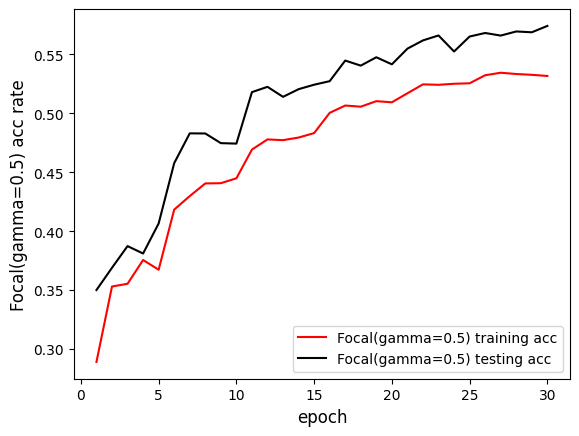

In [227]:
plt.plot(list(range(1,31)),training_acc_Focal1,color='r',label='Focal(gamma=0.5) training acc')
plt.plot(list(range(1,31)),testing_acc_Focal1,color='black',label='Focal(gamma=0.5) testing acc')
plt.xlabel('epoch',size=12)
plt.ylabel('Focal(gamma=0.5) acc rate',size=12)
plt.legend()

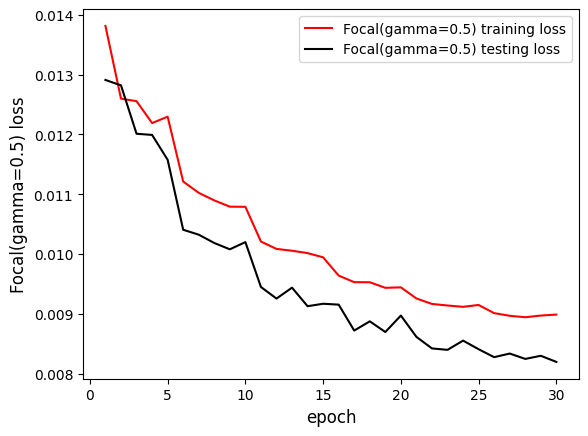

In [228]:
plt.plot(list(range(1,31)),training_loss_Focal1,color='r',label='Focal(gamma=0.5) training loss')
plt.plot(list(range(1,31)),testing_loss_Focal1,color='black',label='Focal(gamma=0.5) testing loss')
plt.xlabel('epoch',size=12)
plt.ylabel('Focal(gamma=0.5) loss',size=12)
plt.legend()

#### Focal loss(gamma=2)

In [229]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
#         F.softmax(x,dim=1)
        return x

model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

In [230]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2, reduction='none'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        ).mean()

In [231]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
criterion = FocalLoss()

def train_batch(model, image, target):
    output = model(image)
    loss =  criterion(output,target)
    return output, loss

def test_batch(model, image, target):
    output = model(image)
    loss = criterion(output,target)
    return output, loss

In [232]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
#         if (epoch +1) == NUM_EPOCHS:
            
#             state = {
#             'state_dict': model.state_dict(),
#             'acc': epoch_acc,
#             'epoch': (epoch+1),
#             }

#             # check the dir
#             if not os.path.exists(SAVE_DIR):
#                 os.makedirs(SAVE_DIR)

#             # save the state
#             torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
            
training_loss_Focal2 = training_loss.copy()
training_acc_Focal2 = training_acc.copy()
testing_loss_Focal2 = testing_loss.copy()
testing_acc_Focal2 = testing_acc.copy()

Epoch: 1/30 Train Loss: 0.0112 Acc: 0.2718
Begin test......
Test Loss: 0.0093 Acc: 0.3697
Epoch: 2/30 Train Loss: 0.0101 Acc: 0.3269
Begin test......
Test Loss: 0.0098 Acc: 0.3628
Epoch: 3/30 Train Loss: 0.0100 Acc: 0.3350
Begin test......
Test Loss: 0.0094 Acc: 0.3608
Epoch: 4/30 Train Loss: 0.0098 Acc: 0.3392
Begin test......
Test Loss: 0.0092 Acc: 0.3827
Epoch: 5/30 Train Loss: 0.0098 Acc: 0.3416
Begin test......
Test Loss: 0.0092 Acc: 0.3713
Epoch: 6/30 Train Loss: 0.0091 Acc: 0.3795
Begin test......
Test Loss: 0.0083 Acc: 0.4249
Epoch: 7/30 Train Loss: 0.0088 Acc: 0.3953
Begin test......
Test Loss: 0.0084 Acc: 0.4242
Epoch: 8/30 Train Loss: 0.0087 Acc: 0.3941
Begin test......
Test Loss: 0.0083 Acc: 0.4306
Epoch: 9/30 Train Loss: 0.0087 Acc: 0.3971
Begin test......
Test Loss: 0.0079 Acc: 0.4515
Epoch: 10/30 Train Loss: 0.0085 Acc: 0.4115
Begin test......
Test Loss: 0.0081 Acc: 0.4445
Epoch: 11/30 Train Loss: 0.0081 Acc: 0.4314
Begin test......
Test Loss: 0.0074 Acc: 0.4749
Epoch: 1

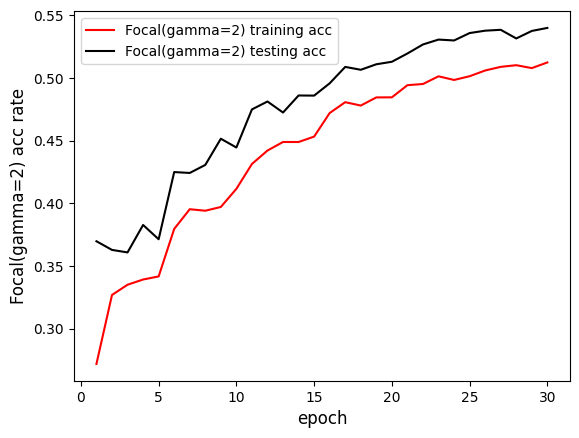

In [233]:
plt.plot(list(range(1,31)),training_acc_Focal2,color='r',label='Focal(gamma=2) training acc')
plt.plot(list(range(1,31)),testing_acc_Focal2,color='black',label='Focal(gamma=2) testing acc')
plt.xlabel('epoch',size=12)
plt.ylabel('Focal(gamma=2) acc rate',size=12)
plt.legend()

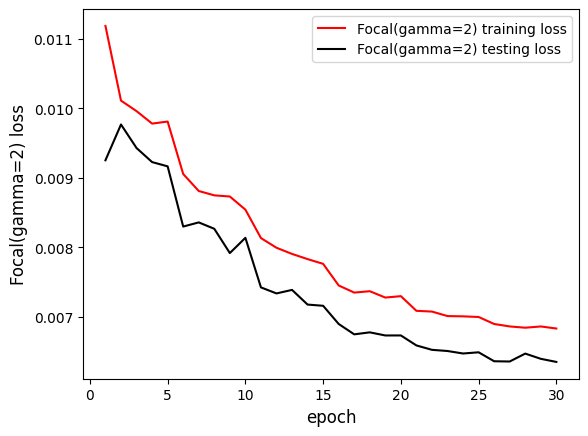

In [234]:
plt.plot(list(range(1,31)),training_loss_Focal2,color='r',label='Focal(gamma=2) training loss')
plt.plot(list(range(1,31)),testing_loss_Focal2,color='black',label='Focal(gamma=2) testing loss')
plt.xlabel('epoch',size=12)
plt.ylabel('Focal(gamma=2) loss',size=12)
plt.legend()

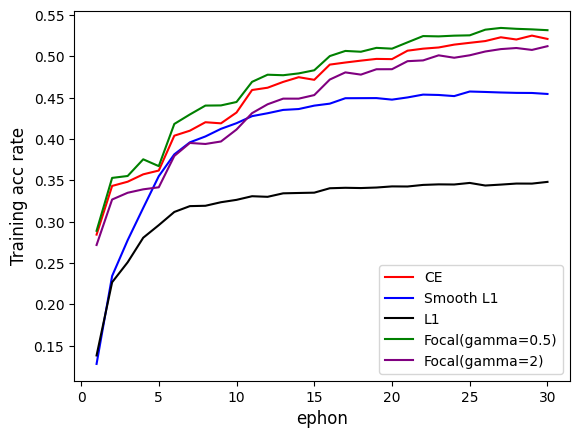

In [235]:
plt.plot(list(range(1,31)),training_acc_CE,color='r',label='CE')
plt.plot(list(range(1,31)),training_acc_SmoothL1,color='b',label='Smooth L1')
plt.plot(list(range(1,31)),training_acc_L1,color='black',label='L1')
plt.plot(list(range(1,31)),training_acc_Focal1,color='g',label='Focal(gamma=0.5)')
plt.plot(list(range(1,31)),training_acc_Focal2,color='purple',label='Focal(gamma=2)')
plt.legend()
plt.xlabel("ephon",size=12)
plt.ylabel("Training acc rate",size=12)
plt.show()

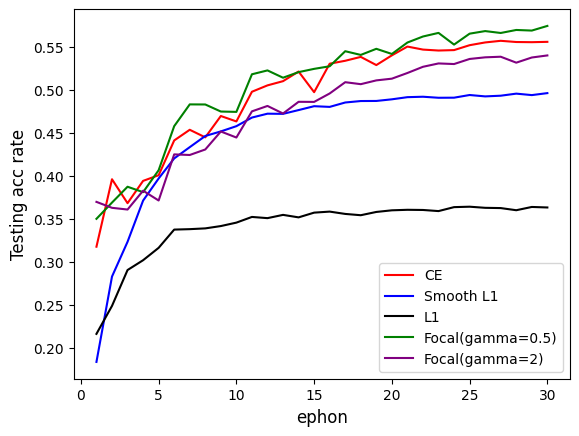

In [236]:
plt.plot(list(range(1,31)),testing_acc_CE,color='r',label='CE')
plt.plot(list(range(1,31)),testing_acc_SmoothL1,color='b',label='Smooth L1')
plt.plot(list(range(1,31)),testing_acc_L1,color='black',label='L1')
plt.plot(list(range(1,31)),testing_acc_Focal1,color='g',label='Focal(gamma=0.5)')
plt.plot(list(range(1,31)),testing_acc_Focal2,color='purple',label='Focal(gamma=2)')
plt.legend()
plt.xlabel("ephon",size=12)
plt.ylabel("Testing acc rate",size=12)
plt.show()

#### test1

In [97]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = F.elu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ConvNet()
model.to(device)

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=0.5, reduction='none'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        ).mean()
    
# optimizer = optim.Adam(model.parameters(), lr=1e-2)
optimizer = optim.SGD(model.parameters(), lr=1e-1,momentum=0.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss()

def train_batch(model, image, target):
    output = model(image)
    loss =  criterion(output,target)
    return output, loss

def test_batch(model, image, target):
    output = model(image)
    loss = criterion(output,target)
    return output, loss

In [98]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(15):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
#         if (epoch +1) == NUM_EPOCHS:
            
#             state = {
#             'state_dict': model.state_dict(),
#             'acc': epoch_acc,
#             'epoch': (epoch+1),
#             }

#             # check the dir
#             if not os.path.exists(SAVE_DIR):
#                 os.makedirs(SAVE_DIR)

#             # save the state
#             torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
            
training_loss_test1 = training_loss.copy()
training_acc_test1 = training_acc.copy()
testing_loss_test1 = testing_loss.copy()
testing_acc_test1 = testing_acc.copy()

Epoch: 1/30 Train Loss: 0.0126 Acc: 0.3568
Begin test......
Test Loss: 0.0106 Acc: 0.4434
Epoch: 2/30 Train Loss: 0.0108 Acc: 0.4390
Begin test......
Test Loss: 0.0098 Acc: 0.4922
Epoch: 3/30 Train Loss: 0.0102 Acc: 0.4655
Begin test......
Test Loss: 0.0094 Acc: 0.5132
Epoch: 4/30 Train Loss: 0.0098 Acc: 0.4875
Begin test......
Test Loss: 0.0091 Acc: 0.5273
Epoch: 5/30 Train Loss: 0.0096 Acc: 0.4993
Begin test......
Test Loss: 0.0092 Acc: 0.5285
Epoch: 6/30 Train Loss: 0.0091 Acc: 0.5226
Begin test......
Test Loss: 0.0084 Acc: 0.5678
Epoch: 7/30 Train Loss: 0.0090 Acc: 0.5282
Begin test......
Test Loss: 0.0083 Acc: 0.5679
Epoch: 8/30 Train Loss: 0.0090 Acc: 0.5320
Begin test......
Test Loss: 0.0082 Acc: 0.5749
Epoch: 9/30 Train Loss: 0.0090 Acc: 0.5338
Begin test......
Test Loss: 0.0084 Acc: 0.5702
Epoch: 10/30 Train Loss: 0.0089 Acc: 0.5371
Begin test......
Test Loss: 0.0082 Acc: 0.5729
Epoch: 11/30 Train Loss: 0.0087 Acc: 0.5480
Begin test......
Test Loss: 0.0080 Acc: 0.5873
Epoch: 1

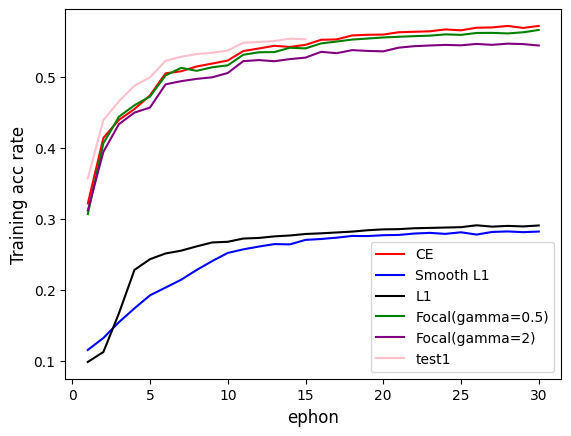

In [99]:
plt.plot(list(range(1,31)),training_acc_CE,color='r',label='CE')
plt.plot(list(range(1,31)),training_acc_SmoothL1,color='b',label='Smooth L1')
plt.plot(list(range(1,31)),training_acc_L1,color='black',label='L1')
plt.plot(list(range(1,31)),training_acc_Focal1,color='g',label='Focal(gamma=0.5)')
plt.plot(list(range(1,31)),training_acc_Focal2,color='purple',label='Focal(gamma=2)')
plt.plot(list(range(1,16)),training_acc_test1,color='pink',label='test1')
plt.legend()
plt.xlabel("ephon",size=12)
plt.ylabel("Training acc rate",size=12)
plt.show()

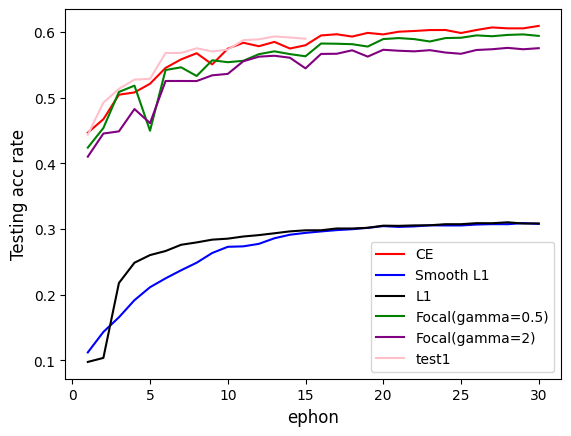

In [100]:
plt.plot(list(range(1,31)),testing_acc_CE,color='r',label='CE')
plt.plot(list(range(1,31)),testing_acc_SmoothL1,color='b',label='Smooth L1')
plt.plot(list(range(1,31)),testing_acc_L1,color='black',label='L1')
plt.plot(list(range(1,31)),testing_acc_Focal1,color='g',label='Focal(gamma=0.5)')
plt.plot(list(range(1,31)),testing_acc_Focal2,color='purple',label='Focal(gamma=2)')
plt.plot(list(range(1,16)),testing_acc_test1,color='pink',label='test1')
plt.legend()
plt.xlabel("ephon",size=12)
plt.ylabel("Testing acc rate",size=12)
plt.show()

#### test2

In [36]:
# Model definition
# def conv3x3(in_planes, out_planes, stride=1):
#     return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_planes, planes, stride=1):
#         super(BasicBlock, self).__init__()
#         self.conv1 = conv3x3(in_planes, planes, stride)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = conv3x3(planes, planes)
#         self.bn2 = nn.BatchNorm2d(planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion*planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion*planes)
#             )

#     def forward(self, x):
#         out = torch.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = torch.relu(out)
#         return out

# class ResNet(nn.Module):
#     def __init__(self, block, num_blocks, num_classes=10):
#         super(ResNet, self).__init__()
#         self.in_planes = 64

#         self.conv1 = conv3x3(3,64)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#         self.linear = nn.Linear(512*block.expansion, num_classes)

#     def _make_layer(self, block, planes, num_blocks, stride):
#         strides = [stride] + [1]*(num_blocks-1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_planes, planes, stride))
#             self.in_planes = planes * block.expansion
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = torch.relu(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = F.avg_pool2d(out, 4)
#         out = out.view(out.size(0), -1)
#         out = self.linear(out)
#         return out

# def ResNet18():
#     return ResNet(BasicBlock, [2,2,2,2])

In [37]:
# model = ResNet18()
# model.to(device)

In [93]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
#         F.softmax(x,dim=1)
        return x

model = ConvNet()
model.to(device)

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2, reduction='none'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        ).mean()
    
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.SGD(model.parameters(), lr=1e-1,momentum=0.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
criterion = nn.CrossEntropyLoss()
# criterion = nn.SmoothL1Loss()
# criterion = FocalLoss()

def train_batch(model, image, target):
    output = model(image)
    loss =  criterion(output,target)
    return output, loss

def test_batch(model, image, target):
    output = model(image)
    loss = criterion(output,target)
    return output, loss

In [101]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(15):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):
        
        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
#         if (epoch +1) == NUM_EPOCHS:
            
#             state = {
#             'state_dict': model.state_dict(),
#             'acc': epoch_acc,
#             'epoch': (epoch+1),
#             }

#             # check the dir
#             if not os.path.exists(SAVE_DIR):
#                 os.makedirs(SAVE_DIR)

#             # save the state
#             torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
            
training_loss_test2 = training_loss.copy()
training_acc_test2 = training_acc.copy()
testing_loss_test2 = testing_loss.copy()
testing_acc_test2 = testing_acc.copy()

Epoch: 1/30 Train Loss: 0.0084 Acc: 0.5613
Begin test......
Test Loss: 0.0078 Acc: 0.5982
Epoch: 2/30 Train Loss: 0.0084 Acc: 0.5593
Begin test......
Test Loss: 0.0079 Acc: 0.5960
Epoch: 3/30 Train Loss: 0.0084 Acc: 0.5621
Begin test......
Test Loss: 0.0078 Acc: 0.6008
Epoch: 4/30 Train Loss: 0.0084 Acc: 0.5648
Begin test......
Test Loss: 0.0078 Acc: 0.5996
Epoch: 5/30 Train Loss: 0.0083 Acc: 0.5653
Begin test......
Test Loss: 0.0077 Acc: 0.6033
Epoch: 6/30 Train Loss: 0.0084 Acc: 0.5652
Begin test......
Test Loss: 0.0077 Acc: 0.6049
Epoch: 7/30 Train Loss: 0.0083 Acc: 0.5670
Begin test......
Test Loss: 0.0077 Acc: 0.6057
Epoch: 8/30 Train Loss: 0.0083 Acc: 0.5675
Begin test......
Test Loss: 0.0077 Acc: 0.6086
Epoch: 9/30 Train Loss: 0.0083 Acc: 0.5700
Begin test......
Test Loss: 0.0077 Acc: 0.6073
Epoch: 10/30 Train Loss: 0.0083 Acc: 0.5680
Begin test......
Test Loss: 0.0077 Acc: 0.6082
Epoch: 11/30 Train Loss: 0.0083 Acc: 0.5669
Begin test......
Test Loss: 0.0077 Acc: 0.6089
Epoch: 1

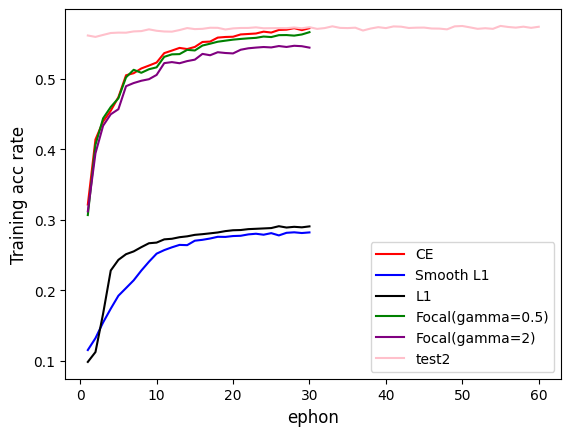

In [104]:
plt.plot(list(range(1,31)),training_acc_CE,color='r',label='CE')
plt.plot(list(range(1,31)),training_acc_SmoothL1,color='b',label='Smooth L1')
plt.plot(list(range(1,31)),training_acc_L1,color='black',label='L1')
plt.plot(list(range(1,31)),training_acc_Focal1,color='g',label='Focal(gamma=0.5)')
plt.plot(list(range(1,31)),training_acc_Focal2,color='purple',label='Focal(gamma=2)')
plt.plot(list(range(1,16)),training_acc_test2,color='pink',label='test2')
plt.legend()
plt.xlabel("ephon",size=12)
plt.ylabel("Training acc rate",size=12)
plt.show()

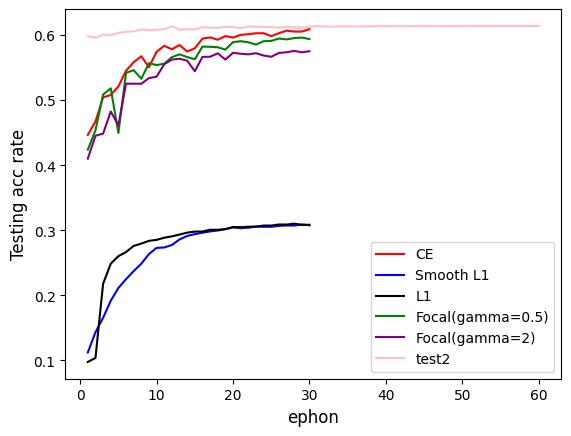

In [105]:
plt.plot(list(range(1,31)),testing_acc_CE,color='r',label='CE')
plt.plot(list(range(1,31)),testing_acc_SmoothL1,color='b',label='Smooth L1')
plt.plot(list(range(1,31)),testing_acc_L1,color='black',label='L1')
plt.plot(list(range(1,31)),testing_acc_Focal1,color='g',label='Focal(gamma=0.5)')
plt.plot(list(range(1,31)),testing_acc_Focal2,color='purple',label='Focal(gamma=2)')
plt.plot(list(range(1,16)),testing_acc_test2,color='pink',label='test2')
plt.legend()
plt.xlabel("ephon",size=12)
plt.ylabel("Testing acc rate",size=12)
plt.show()

#### VGG

In [368]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16,self).__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.conv2=nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.conv3=nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
#         self.conv4=nn.Sequential(
#             nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=1,stride=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1,stride=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1,stride=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2,stride=2),
#         )
#         self.conv5=nn.Sequential(
#             nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1,stride=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1,stride=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1,stride=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2,stride=2),
#         )
        self.feature=nn.Sequential(
            self.conv1,
            self.conv2,
            self.conv3,
#             self.conv4,
#             self.conv5,
        )
        self.flatten=nn.Flatten()
        self.fc=nn.Sequential(
            nn.Linear(256*4*4,256),
            nn.ReLU(inplace=True),
#             nn.Dropout(0.4),
            nn.Linear(256,256),
            nn.ReLU(inplace=True),
#             nn.Dropout(0.4),
            nn.Linear(256,10),
#             nn.Softmax(10)
        )
    def forward(self,x):
        x=self.feature(x)
        # x=self.flatten(x)
        x = x.view(x.size(0), -1)
        x=self.fc(x)
        return x

In [393]:
model = VGG16()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=1e-1,momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
criterion = nn.CrossEntropyLoss()
# criterion = nn.SmoothL1Loss()
# criterion = FocalLoss()

def train_batch(model, image, target):
    output = model(image)
    loss =  criterion(output,target)
    return output, loss

def test_batch(model, image, target):
    output = model(image)
    loss = criterion(output,target)
    return output, loss

In [200]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(30):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
#         if (epoch +1) == NUM_EPOCHS:
            
#             state = {
#             'state_dict': model.state_dict(),
#             'acc': epoch_acc,
#             'epoch': (epoch+1),
#             }

#             # check the dir
#             if not os.path.exists(SAVE_DIR):
#                 os.makedirs(SAVE_DIR)

#             # save the state
#             torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
            
training_loss_vgg = training_loss.copy()
training_acc_vgg = training_acc.copy()
testing_loss_vgg = testing_loss.copy()
testing_acc_vgg = testing_acc.copy()

Epoch: 1/30 Train Loss: 0.0180 Acc: 0.1011
Begin test......
Test Loss: 0.0182 Acc: 0.1264
Epoch: 2/30 Train Loss: 0.0159 Acc: 0.2403
Begin test......
Test Loss: 0.0143 Acc: 0.3270
Epoch: 3/30 Train Loss: 0.0139 Acc: 0.3385
Begin test......
Test Loss: 0.0129 Acc: 0.3961
Epoch: 4/30 Train Loss: 0.0121 Acc: 0.4304
Begin test......
Test Loss: 0.0117 Acc: 0.4550
Epoch: 5/30 Train Loss: 0.0105 Acc: 0.5080
Begin test......
Test Loss: 0.0097 Acc: 0.5745
Epoch: 6/30 Train Loss: 0.0085 Acc: 0.6084
Begin test......
Test Loss: 0.0080 Acc: 0.6406
Epoch: 7/30 Train Loss: 0.0076 Acc: 0.6526
Begin test......
Test Loss: 0.0069 Acc: 0.6846
Epoch: 8/30 Train Loss: 0.0068 Acc: 0.6880
Begin test......
Test Loss: 0.0063 Acc: 0.7191
Epoch: 9/30 Train Loss: 0.0062 Acc: 0.7194
Begin test......
Test Loss: 0.0059 Acc: 0.7376
Epoch: 10/30 Train Loss: 0.0057 Acc: 0.7437
Begin test......
Test Loss: 0.0054 Acc: 0.7592
Epoch: 11/30 Train Loss: 0.0048 Acc: 0.7853
Begin test......
Test Loss: 0.0051 Acc: 0.7830
Epoch: 1

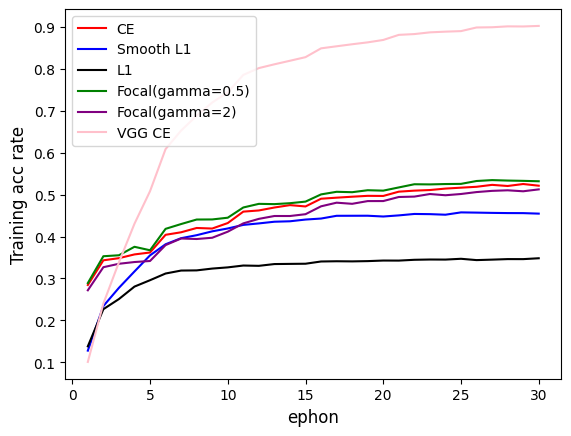

In [265]:
plt.plot(list(range(1,31)),training_acc_CE,color='r',label='CE')
plt.plot(list(range(1,31)),training_acc_SmoothL1,color='b',label='Smooth L1')
plt.plot(list(range(1,31)),training_acc_L1,color='black',label='L1')
plt.plot(list(range(1,31)),training_acc_Focal1,color='g',label='Focal(gamma=0.5)')
plt.plot(list(range(1,31)),training_acc_Focal2,color='purple',label='Focal(gamma=2)')
plt.plot(list(range(1,31)),training_acc_vgg,color='pink',label='VGG CE')
plt.legend()
plt.xlabel("ephon",size=12)
plt.ylabel("Training acc rate",size=12)
plt.show()

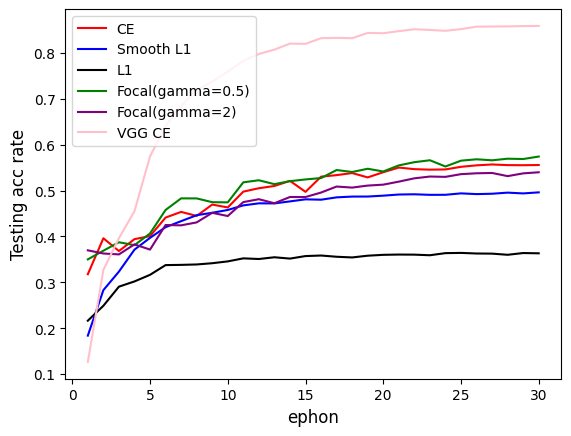

In [266]:
plt.plot(list(range(1,31)),testing_acc_CE,color='r',label='CE')
plt.plot(list(range(1,31)),testing_acc_SmoothL1,color='b',label='Smooth L1')
plt.plot(list(range(1,31)),testing_acc_L1,color='black',label='L1')
plt.plot(list(range(1,31)),testing_acc_Focal1,color='g',label='Focal(gamma=0.5)')
plt.plot(list(range(1,31)),testing_acc_Focal2,color='purple',label='Focal(gamma=2)')
plt.plot(list(range(1,31)),testing_acc_vgg,color='pink',label='VGG CE')
plt.legend()
plt.xlabel("ephon",size=12)
plt.ylabel("Testing acc rate",size=12)
plt.show()

#### v Focal(gamma=2)

In [245]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16,self).__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.conv2=nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.conv3=nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
#         self.conv4=nn.Sequential(
#             nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=1,stride=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1,stride=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1,stride=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2,stride=2),
#         )
#         self.conv5=nn.Sequential(
#             nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1,stride=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1,stride=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1,stride=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2,stride=2),
#         )
        self.feature=nn.Sequential(
            self.conv1,
            self.conv2,
            self.conv3,
#             self.conv4,
#             self.conv5,
        )
        self.flatten=nn.Flatten()
        self.fc=nn.Sequential(
            nn.Linear(256*4*4,256),
            nn.ReLU(inplace=True),
#             nn.Dropout(0.4),
            nn.Linear(256,256),
            nn.ReLU(inplace=True),
#             nn.Dropout(0.4),
            nn.Linear(256,10),
#             nn.Softmax(10)
        )
    def forward(self,x):
        x=self.feature(x)
        # x=self.flatten(x)
        x = x.view(x.size(0), -1)
        x=self.fc(x)
        return x
    
model = VGG16()
model.to(device)

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2, reduction='none'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        ).mean()

optimizer = optim.SGD(model.parameters(), lr=1e-1,momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
# criterion = nn.CrossEntropyLoss()
# criterion = nn.SmoothL1Loss()
criterion = FocalLoss()

def train_batch(model, image, target):
    output = model(image)
    loss =  criterion(output,target)
    return output, loss

def test_batch(model, image, target):
    output = model(image)
    loss = criterion(output,target)
    return output, loss

In [246]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(30):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
#         if (epoch +1) == NUM_EPOCHS:
            
#             state = {
#             'state_dict': model.state_dict(),
#             'acc': epoch_acc,
#             'epoch': (epoch+1),
#             }

#             # check the dir
#             if not os.path.exists(SAVE_DIR):
#                 os.makedirs(SAVE_DIR)

#             # save the state
#             torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
            
training_loss_vggFocal2 = training_loss.copy()
training_acc_vggFocal2 = training_acc.copy()
testing_loss_vggFocal2 = testing_loss.copy()
testing_acc_vggFocal2 = testing_acc.copy()

Epoch: 1/30 Train Loss: 0.0146 Acc: 0.1011
Begin test......
Test Loss: 0.0148 Acc: 0.1099
Epoch: 2/30 Train Loss: 0.0123 Acc: 0.2025
Begin test......
Test Loss: 0.0112 Acc: 0.2669
Epoch: 3/30 Train Loss: 0.0099 Acc: 0.3202
Begin test......
Test Loss: 0.0091 Acc: 0.3693
Epoch: 4/30 Train Loss: 0.0082 Acc: 0.4093
Begin test......
Test Loss: 0.0069 Acc: 0.4786
Epoch: 5/30 Train Loss: 0.0073 Acc: 0.4740
Begin test......
Test Loss: 0.0067 Acc: 0.5124
Epoch: 6/30 Train Loss: 0.0055 Acc: 0.5834
Begin test......
Test Loss: 0.0051 Acc: 0.5977
Epoch: 7/30 Train Loss: 0.0047 Acc: 0.6337
Begin test......
Test Loss: 0.0043 Acc: 0.6670
Epoch: 8/30 Train Loss: 0.0042 Acc: 0.6674
Begin test......
Test Loss: 0.0042 Acc: 0.6730
Epoch: 9/30 Train Loss: 0.0039 Acc: 0.6905
Begin test......
Test Loss: 0.0036 Acc: 0.7238
Epoch: 10/30 Train Loss: 0.0035 Acc: 0.7173
Begin test......
Test Loss: 0.0036 Acc: 0.7229
Epoch: 11/30 Train Loss: 0.0028 Acc: 0.7674
Begin test......
Test Loss: 0.0028 Acc: 0.7707
Epoch: 1

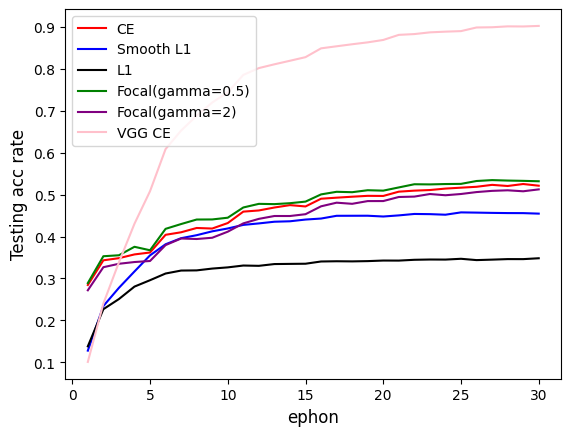

In [269]:
plt.plot(list(range(1,31)),training_acc_CE,color='r',label='CE')
plt.plot(list(range(1,31)),training_acc_SmoothL1,color='b',label='Smooth L1')
plt.plot(list(range(1,31)),training_acc_L1,color='black',label='L1')
plt.plot(list(range(1,31)),training_acc_Focal1,color='g',label='Focal(gamma=0.5)')
plt.plot(list(range(1,31)),training_acc_Focal2,color='purple',label='Focal(gamma=2)')
plt.plot(list(range(1,31)),training_acc_vgg,color='pink',label='VGG CE')
# plt.plot(list(range(1,31)),training_acc_vggFocal2,color='black',label='VGG Focal2')
# plt.plot(list(range(1,31)),training_acc_L1,color='black',label='L1')
plt.legend()
plt.xlabel("ephon",size=12)
plt.ylabel("Testing acc rate",size=12)
plt.show()

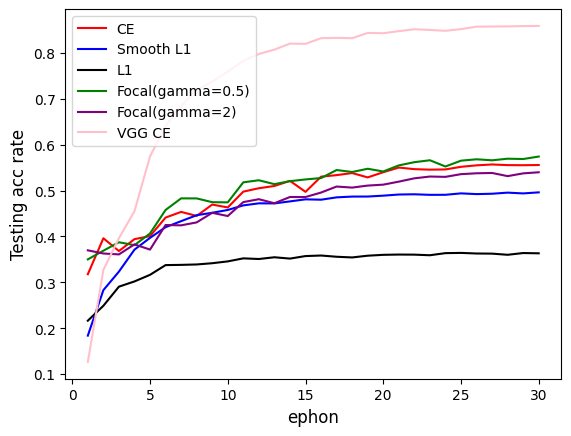

In [270]:
plt.plot(list(range(1,31)),testing_acc_CE,color='r',label='CE')
plt.plot(list(range(1,31)),testing_acc_SmoothL1,color='b',label='Smooth L1')
plt.plot(list(range(1,31)),testing_acc_L1,color='black',label='L1')
plt.plot(list(range(1,31)),testing_acc_Focal1,color='g',label='Focal(gamma=0.5)')
plt.plot(list(range(1,31)),testing_acc_Focal2,color='purple',label='Focal(gamma=2)')
plt.plot(list(range(1,31)),testing_acc_vgg,color='pink',label='VGG CE')
# plt.plot(list(range(1,31)),testing_acc_vggFocal2,color='black',label='VGG Focal2')
plt.legend()
plt.xlabel("ephon",size=12)
plt.ylabel("Testing acc rate",size=12)
plt.show()